# **Bank Customer Churn Prediction using Logistic Regression**
Hello friends, In this kernel, I will predict the customer churn for a bank and understand the key factors behind their churn by using a famous supervised machine learning algorithm "Logistic Regression".

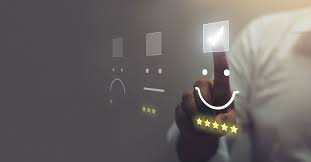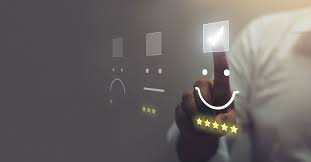

**If this kernel helped in your learning, then please UPVOTE – because they are the source of motivation!**

## **Context**
Dataset contain list of customers who are either withdrawing or retaining their account with the bank. With the help of Logistic Regression model we will try to analyse the main factors behind the churn and maintain accuracy.

In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [ ]:
bank= pd.read_csv('../input/bank-customers/Churn Modeling.csv')
bank.head()

In [ ]:
bank.info()

In [ ]:
bank.describe().T

In [ ]:
# checking null values
bank.isna().sum()

Removing the unnecessary columns from bank dataset

In [ ]:
bank.drop(['RowNumber','Surname','CustomerId'],1,inplace=True)

In [ ]:
bank.head()

In [ ]:
# treating categorical columns
bank.Geography.value_counts(dropna=False)

In [ ]:
from sklearn import preprocessing
label_encoder= preprocessing.LabelEncoder()

**Label Encoding** refers to converting the labels into numeric form so as to convert it into the machine-readable form. 

In [ ]:
bank.Geography=label_encoder.fit_transform(bank.Geography)

In [ ]:
# similarly doing label encoding for other categorical columns
bank.Gender=label_encoder.fit_transform(bank.Gender)

In [ ]:
# Let's have a look of our dataset
bank.head()

## Model Building

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# train_test_split
df_train,df_test=train_test_split(bank,train_size=0.7, test_size=0.3, random_state=100)

We have kept train and test size as 70% and 30% respectively

In [ ]:
df_train.describe().T

In [ ]:
df_test.describe().T

We can see that our **target variable** (*Exited*) in both the dataset (train and test) have equal distribution of 0's and 1's (see the mean).

### Feature Scaling

**Feature Scaling** is a technique to standardize the *independent features* present in the data in a fixed range. It is performed during the data pre-processing to handle highly varying magnitudes or values or units. If feature scaling is not done, then a machine learning algorithm tends to weigh greater values, higher and consider smaller values as the lower values, regardless of the unit of the values.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()

In [ ]:
col= df_train.columns
col= col.drop('Exited')

In [ ]:
df_train[col]= scaler.fit_transform(df_train[col])

In [ ]:
df_test[col]= scaler.transform(df_test[col])

**Defining X and y**

In [ ]:
# train dataset
y_train= df_train.pop('Exited')
X_train= df_train

In [ ]:
# test dataset
y_test= df_test.pop('Exited')
X_test= df_test

In [ ]:
import statsmodels.api as sm

In [ ]:
# Logistic Regression
lr=sm.GLM(y_train,sm.add_constant(X_train),family=sm.families.Binomial())

In [ ]:
# fitting the model
lr1= lr.fit()
print(lr1.summary())

Dropping ***HasCrCard*** beacuse it's **p-value** is greater than our assumed signifiance level of 0.05

In [ ]:
X_train.drop('HasCrCard',1,inplace=True)

After dropping we will again build our model with the remaing features/columns

In [ ]:
lr=sm.GLM(y_train,sm.add_constant(X_train),family=sm.families.Binomial())

In [ ]:
# fitting the model
lr2= lr.fit()
print(lr2.summary())

Dropping ***NumOfProducts*** beacuse it's **p-value** is greater than our assumed signifiance level of 0.05

In [ ]:
X_train.drop('NumOfProducts',1,inplace=True)

In [ ]:
lr=sm.GLM(y_train,sm.add_constant(X_train),family=sm.families.Binomial())

In [ ]:
# fitting the model
lr3= lr.fit()
print(lr3.summary())

### Checking Multicollinearity using VIF

A **variance inflation factor** **(VIF)** provides a measure of *multicollinearity* among the independent variables in a multiple regression model.

Detecting *multicollinearity* is important because while multicollinearity does not reduce the explanatory power of the model, it does reduce the statistical significance of the independent variables. 

A large **variance inflation factor** **(VIF)** on an independent variable indicates a highly collinear relationship to the other variables that should be considered or adjusted for in the structure of the model and selection of independent variables.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

**VIF** less than 10 is acceptable.
So we will go with the current set of variables/features/columns

### Prediction

In [ ]:
y_train_pred=lr3.predict(sm.add_constant(X_train))

In [ ]:
y_train_pred.head()

In [ ]:
# converting prediction in the form of a dataframe for better understanding
score=pd.DataFrame({'CustID':y_train.index,'Churn':y_train.values,'Churn_prob':y_train_pred})
score.set_index('CustID',inplace=True)
score.head()

In [ ]:
# Let's create columns with different probability cutoffs
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    score[i]= score.Churn_prob.map(lambda x: 1 if x > i else 0)
score.head()

### ROC Curve

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False)
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve( score.Churn, score.Churn_prob, drop_intermediate = False )

In [ ]:
draw_roc(score.Churn, score.Churn_prob)

### Finding Optimal Cutoff Probability 
Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.

In [ ]:
from sklearn.metrics import confusion_matrix

cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(score.Churn, score[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

In [ ]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

**From the curve above, 0.2 is the optimum point to take it as a cutoff probability.**

In [ ]:
score['final_prediction'] = score.Churn_prob.map( lambda x: 1 if x > 0.3 else 0)
score.head()

In [ ]:
# Let's check the accuracy on train dataset
metrics.accuracy_score(score.Churn,score.final_prediction)

We got an accuracy of **77.6%** on train dataset

In [ ]:
col= X_train.columns

### Operations on the Test Dataset

We will use our model **(lr3)** for prediction on the test dataset

In [ ]:
y_test_pred=lr3.predict(sm.add_constant(X_test[col]))

In [ ]:
# DataFrame
score2=pd.DataFrame({'CustID':y_test.index,'Churn':y_test.values,'Churn_prob':y_test_pred})
score2.set_index('CustID',inplace=True)
score2.head()

In [ ]:
score2['Final_predction']=score2.Churn_prob.map(lambda x:1 if x>0.2 else 0)

In [ ]:
score2.head()

In [ ]:
# Let's check the accuracy on test dataset
metrics.accuracy_score(score2.Churn,score2.Final_predction)

We got an accuracy of **70%** on our test dataset

### **Summary**
#### Accuracy on train is 77.6%
#### Accuracy on test is 70.0%
#### We can say that our model (lr3) is robust and generalisable.

## **Thank You**